# 本文件为真实数据拟合的GRU模型，用于预测材料的力学性能。

In [320]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [321]:
current_directory = os.getcwd()
print(current_directory)

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("No GPU available, using CPU instead.")

/home/redfu/work/Constitutive_Equation/stress_strain_fitting
Using GPU: NVIDIA GeForce RTX 2080 Ti


In [322]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
import os

# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")


系统已安装 Arial 字体


In [323]:
import numpy as np

def ihs_transform(data):
    """
    使用反双曲正弦变换（IHS）对数据进行对数化处理，可以直接处理负值和零值
    
    参数:
    data: ndarray, 输入数据，假设每一列是一个特征
    
    返回:
    ihs_data: ndarray, IHS变换后的数据
    """
    ihs_data = np.log(data + np.sqrt(data**2 + 1))
    return ihs_data

def inverse_ihs_transform(ihs_data):
    """
    反双曲正弦变换（IHS）的逆变换，将数据还原为原始值
    
    参数:
    ihs_data: ndarray, IHS变换后的数据
    
    返回:
    data: ndarray, 还原后的数据
    """
    data = np.sinh(ihs_data)
    return data


In [324]:
# 设置数据类型
DTYPE = torch.float32
# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
# 读取数据
url = 'data/sx_real_data.xlsx'
df = pd.read_excel(url, sheet_name=None)
data_HF = [[k, v] for k, v in df.items()]  # k is the sheet name, v is the pandas df
# 循环遍历 data_HF 列表并获取下标
data_train=pd.DataFrame()
data_valid=pd.DataFrame()
data_special=pd.DataFrame()
for i, (sheet_name, sheet_data) in enumerate(data_HF):
    # #去除 sheet_data 中的零值
    # sheet_data = sheet_data[(sheet_data != 0).all(axis=1)]
    if i==5:
        data_valid=sheet_data
        data_train=pd.concat([data_train, sheet_data], ignore_index=True)

df_hf = pd.concat([data_train, data_valid], ignore_index=True)


In [325]:
# 创建MinMaxScaler对象
X_scaler_gamma = MinMaxScaler()
X_scaler_gammadot = MinMaxScaler()
X_scaler_gamma_0 = MinMaxScaler()
X_scaler_time = MinMaxScaler()
X_scaler_delta_t = MinMaxScaler()
y_scaler = MinMaxScaler()


# 从训练数据提取特征和标签
X_train_gamma = data_train[['gamma']].values
X_train_gammadot = data_train[['gammadot']].values
X_train_gamma_0 = data_train[['gamma_0']].values
X_train_time = data_train[['Time']].values
X_train_delta_t = data_train[['delta_t']].values
y_train_raw = data_train[['sigma']].values
# 对训练数据进行对数变换
X_train_gamma_log = ihs_transform (X_train_gamma)
X_train_gammadot_log = ihs_transform(X_train_gammadot)
X_train_gamma_0_log = ihs_transform(X_train_gamma_0)
X_train_time_log = ihs_transform(X_train_time)
X_train_delta_t_log = ihs_transform(X_train_delta_t)
y_train_raw_log = ihs_transform(y_train_raw)

# 对训练数据进行归一化并保存归一化参数
X_train_gamma_norm = X_scaler_gamma.fit_transform(X_train_gamma_log)
X_train_gammadot_norm = X_scaler_gammadot.fit_transform(X_train_gammadot_log)
X_train_gamma_0_norm = X_scaler_gamma_0.fit_transform(X_train_gamma_0_log)
X_train_time_norm = X_scaler_time.fit_transform(X_train_time_log)
X_train_delta_t_norm = X_scaler_delta_t.fit_transform(X_train_delta_t_log)
y_train_normalized = y_scaler.fit_transform(y_train_raw_log)

# 从验证数据提取特征和标签
X_valid_gamma = data_valid[['gamma']].values
X_valid_gammadot = data_valid[['gammadot']].values
X_valid_gamma_0 = data_valid[['gamma_0']].values
X_valid_time = data_valid[['Time']].values
X_valid_delta_t = data_valid[['delta_t']].values
y_valid_raw = data_valid[['sigma']].values

# 验证数据进行对数变换
X_valid_gamma_log = ihs_transform(X_valid_gamma)
X_valid_gammadot_log = ihs_transform(X_valid_gammadot)
X_valid_gamma_0_log = ihs_transform(X_valid_gamma_0)
X_valid_time_log = ihs_transform(X_valid_time)
X_valid_delta_t_log = ihs_transform(X_valid_delta_t)
y_valid_raw_log = ihs_transform(y_valid_raw)


# 使用训练数据的归一化参数对验证数据进行归一化
X_valid_gamma_norm = X_scaler_gamma.transform(X_valid_gamma_log)
X_valid_gammadot_norm = X_scaler_gammadot.transform(X_valid_gammadot_log)
X_valid_gamma_0_norm = X_scaler_gamma_0.transform(X_valid_gamma_0_log)
X_valid_time_norm = X_scaler_time.transform(X_valid_time_log)
X_valid_delta_t_norm = X_scaler_delta_t.transform(X_valid_delta_t_log)
y_valid_normalized = y_scaler.transform(y_valid_raw_log)

# 合并归一化后的特征
X_train_normalized = np.hstack((X_train_gamma_norm, X_train_gammadot_norm, X_train_gamma_0_norm,X_train_time_norm,X_train_delta_t_norm))
X_valid_normalized = np.hstack((X_valid_gamma_norm, X_valid_gammadot_norm, X_valid_gamma_0_norm,X_valid_time_norm,X_valid_delta_t_norm))

print(f"训练数据形状: X={X_train_normalized.shape}, y={y_train_normalized.shape}")
print(f"验证数据形状: X={X_valid_normalized.shape}, y={y_valid_normalized.shape}")

# 将归一化后的训练数据转换为tensor
X_data_HF = torch.tensor(X_train_normalized, dtype=torch.float32)
y_data_HF = torch.tensor(y_train_normalized, dtype=torch.float32)

# 将归一化后的验证数据转换为tensor
X_data_valid = torch.tensor(X_valid_normalized, dtype=torch.float32)
y_data_valid = torch.tensor(y_valid_normalized, dtype=torch.float32)

# 合并特征和标签
Xy_data_HF = torch.cat([X_data_HF, y_data_HF], dim=1)

# 定义模型
in_dim, out_dim = 5, 1

训练数据形状: X=(513, 5), y=(513, 1)
验证数据形状: X=(513, 5), y=(513, 1)


In [326]:
# 定义时间步长
time_steps = 30

# 动态窗口实现
def create_dynamic_window(data, time_steps):
    """
    通过动态窗口将数据调整为适合 LSTM 输入的格式。
    :param data: 输入数据，形状为 (num_samples, ...)
    :param time_steps: 时间步长
    :return: 调整后的数据，形状为 (num_samples - time_steps + 1, time_steps, ...)
    """
    num_samples = data.shape[0]
    if num_samples < time_steps:
        raise ValueError("样本数量必须大于等于时间步长")
    
    # 创建动态窗口
    windowed_data = []
    for i in range(num_samples - time_steps + 1):
        window = data[i:i + time_steps]
        windowed_data.append(window)
    
    return torch.stack(windowed_data)

# 调整 X_data_HF 和 y_data_HF
# 根据 gamma_0 的值对 X_data_HF 进行分组
unique_gamma_0 = torch.unique(X_data_HF[:, 2])  # 假设 gamma_0 在第三列
grouped_X_data = []
grouped_y_data = []

for gamma_0_value in unique_gamma_0:
    # 选择当前 gamma_0 值对应的数据
    group_mask = X_data_HF[:, 2] == gamma_0_value
    group_X_data = X_data_HF[group_mask]
    group_y_data = y_data_HF[group_mask]
    
    # 对当前组数据应用动态窗口
    windowed_group_X_data = create_dynamic_window(group_X_data, time_steps)
    windowed_group_y_data = create_dynamic_window(group_y_data, time_steps)
    
    # 通常是目标值，只需要取每个窗口的最后一个时间步的值
    windowed_group_y_data = windowed_group_y_data[:, -1, :]
    
    grouped_X_data.append(windowed_group_X_data)
    grouped_y_data.append(windowed_group_y_data)

# 将所有组的数据拼接起来
X_data_HF = torch.cat(grouped_X_data, dim=0)
y_data_HF = torch.cat(grouped_y_data, dim=0)

print(X_data_HF.shape)
print(y_data_HF.shape)

torch.Size([484, 30, 5])
torch.Size([484, 1])


In [327]:
# 调整 X_data_valid
X_data_valid = create_dynamic_window(X_data_valid, time_steps)
# 调整 y_data_HF
# 注意：y_data_HF 通常是目标值，只需要取最后一个时间步的值
y_data_valid = y_data_valid[time_steps-1:]

In [328]:
class GRU_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model using GRU."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 hidden_size=20,  # GRU 隐藏层的维度
                 num_layers=4,    # GRU 层数
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(GRU_NeuralNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        # 添加 GRU 层
        self.gru = nn.GRU(input_dim, hidden_size, num_layers, batch_first=True)
        
        # 添加第一层全连接层（从 GRU 的隐藏状态映射到中间层）
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # 中间层的维度可以与 hidden_size 相同
        
        # 添加第二层全连接层（从中间层映射到输出维度）
        self.out = nn.Linear(hidden_size, output_dim)
        
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(param)
            nn.init.xavier_normal_(self.fc1.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            for name, param in self.gru.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):
        # GRU 输入形状: (batch_size, seq_len, input_dim)
        # GRU 输出形状: (batch_size, seq_len, hidden_size)
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(X.device)
        
        # 通过 GRU 层
        gru_out, _ = self.gru(X, h0)
        
        # 取最后一个时间步的输出
        last_time_step = gru_out[:, -1, :]  # (batch_size, hidden_size)
        
        # 通过第一层全连接层
        Z = self.fc1(last_time_step)
        
        # 应用激活函数（如果需要）
        if self.activation is not None:
            Z = self.activation(Z)
        
        # 通过第二层全连接层
        Z = self.out(Z)
        
        return Z

In [329]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self, model):
        self.model = model # 
        # Initialize history of losses and global iteration counter
        self.hist =  [[], []] # loss历史列表,0:train loss ;1:valid loss
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_HF, y_data_HF,X_data_valid,y_data_valid):
        y_pred_valid = self.model(X_data_valid)    
    
        y_pred_HF = self.model(X_data_HF)

        Loss_L2 = 1e-5 * sum(torch.sum(w_**2) for w_ in self.model.parameters())
       # 计算高频数据集的 Huber Loss
        Loss_data_HF = F.smooth_l1_loss(y_pred_HF, y_data_HF) + Loss_L2
        # # 计算 dsigma/dt
        # # 使用有限差分法计算应力对时间的导数
        # dsigma_dt = (y_pred_HF[1:,0] - y_pred_HF[:-1,0]) / 0.01
        # # 计算残差
        # residual = torch.mean((dsigma_dt + 10 * y_pred_HF[1:, 0] - X_data_HF[1:, -1, 1])**2)
        # 计算验证集的 Huber Loss
        Loss_data_valid = F.smooth_l1_loss(y_pred_valid, y_data_valid) + Loss_L2
        return Loss_data_HF,Loss_data_valid
    
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer, data, scheduler, batch_size, N=1001):
        """This method performs a gradient descent type optimization."""
        # 解包数据
        X_data_HF, y_data_HF, X_data_valid, y_data_valid = data

        # 创建训练数据集和 DataLoader
        train_dataset = TensorDataset(X_data_HF, y_data_HF)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        for i in range(N):
            # 初始化 epoch 的总损失
            epoch_loss_sum = 0.0
            num_batches = 0
            # 遍历每个批次
            for X_batch, y_batch in train_loader:
                # 梯度清0
                optimizer.zero_grad()
                # 计算 loss
                loss, _ = self.loss_fn(X_batch, y_batch, X_data_valid, y_data_valid)

                # 反向传播计算梯度
                loss.backward()

                # 反向传播更新权重和偏置
                optimizer.step()

                # 累加每个批次的损失
                epoch_loss_sum += loss.item()
                num_batches += 1

            # 计算 epoch 的平均损失
            # 在整个验证集上计算验证损失
            loss_train, loss_valid = self.loss_fn(X_data_HF, y_data_HF, X_data_valid, y_data_valid)

            # 记录 epoch 的平均损失
            self.current_loss = loss_train.item()
            self.valid_loss = loss_valid.item()
            # 根据 epoch 的平均损失调度学习率
            scheduler.step(loss_train)
            
            # 计算相对误差
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error, N)  # 将 max_relative_error 传递给回调函数
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3:  # 以 % 为单位
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                                                                    self.current_loss,
                                                                                                    np.round(self.max_relative_error, 3)))
                break
    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 100 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist[0].append(self.current_loss)
        self.hist[1].append(self.valid_loss)
        self.iter+=1
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(8, 6),dpi=600)
            ax = fig.add_subplot(111)

        # 绘制训练集损失曲线
        ax.semilogy(range(len(self.hist[0])), self.hist[0], 'b-', label='Training Loss')
        
        # 绘制验证集损失曲线
        ax.semilogy(range(len(self.hist[1])), self.hist[1], 'g-', label='Validation Loss')

        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('Loss')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        ax.legend()  # 添加图例
        return ax

In [330]:
model= GRU_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_layers=4,
                             hidden_size=30,
                             activation='relu')

# 初始化 PINNSolver
solver = PINNSolver(model)
model = model.to(device)  # 将模型移动到 GPU
X_data_HF,y_data_HF,X_data_valid,y_data_valid
# 假设 X_data_HF, y_data_HF, X_data_valid, y_data_valid 是 PyTorch 张量
X_data_HF = X_data_HF.to(device)  # 将训练集输入数据移动到 GPU
y_data_HF = y_data_HF.to(device)  # 将训练集标签数据移动到 GPU

X_data_valid = X_data_valid.to(device)  # 将验证集输入数据移动到 GPU
y_data_valid = y_data_valid.to(device)  # 将验证集标签数据移动到 GPU

In [331]:
# 定义学习率调度器
lr = 1e-4
optimizer = optim.Adam(list(model.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
batch=484
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(20000) + 1  # 训练迭代次数

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        t0 = time()
        solver.solve_with_PyTorch_optimizer(optimizer, [X_data_HF,y_data_HF,X_data_valid,y_data_valid],scheduler,batch,N=N)
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

It 0,000: Loss = 2.5118e-01, Max. rel. error = 100 %


/home/redfu/anaconda3/envs/PINN/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


It 0,100: Loss = 3.9612e-02, Max. rel. error = 32.52 %
It 0,200: Loss = 9.2525e-03, Max. rel. error = 4.94 %
It 0,300: Loss = 8.6466e-03, Max. rel. error = 0.98 %
It 0,400: Loss = 8.0033e-03, Max. rel. error = 1.64 %
It 0,500: Loss = 7.3116e-03, Max. rel. error = 1.84 %
It 0,600: Loss = 6.5541e-03, Max. rel. error = 2.3 %
It 0,700: Loss = 5.6766e-03, Max. rel. error = 3.04 %
It 0,800: Loss = 4.7128e-03, Max. rel. error = 3.98 %
It 0,900: Loss = 3.6990e-03, Max. rel. error = 4.71 %
It 1,000: Loss = 3.1174e-03, Max. rel. error = 2.24 %
It 1,100: Loss = 2.9054e-03, Max. rel. error = 0.98 %
It 1,200: Loss = 2.7916e-03, Max. rel. error = 0.66 %
It 1,300: Loss = 2.7076e-03, Max. rel. error = 0.54 %
It 1,400: Loss = 2.6374e-03, Max. rel. error = 0.48 %
It 1,500: Loss = 2.5747e-03, Max. rel. error = 0.45 %
It 1,600: Loss = 2.5173e-03, Max. rel. error = 0.42 %
It 1,700: Loss = 2.4635e-03, Max. rel. error = 0.4 %
It 1,800: Loss = 2.4130e-03, Max. rel. error = 0.39 %
It 1,900: Loss = 2.3651e-03, 

<Axes: xlabel='$n_{epoch}$', ylabel='Loss'>

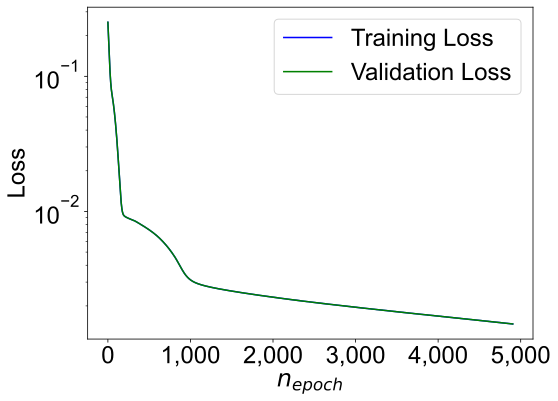

In [332]:
solver.plot_loss_history()

y_train_pred shape: (484, 1)
y_train_raw shape: (513, 1)
y_valid_pred shape: (484, 1)
y_valid_raw shape: (513, 1)


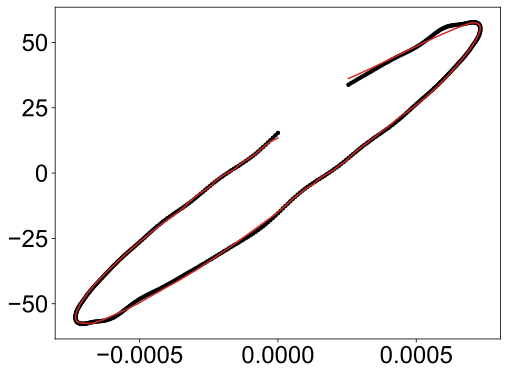

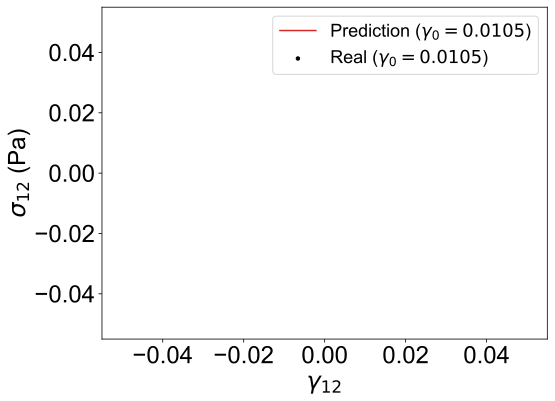

In [333]:
# 统一设置字体为 Arial 24 pt
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 24 # 三拼图为36，单图为12最佳
model.eval()
# 颜色字典
colors = {
    'red': 'tab:red',
    'orange': 'tab:orange', 
    'yellow': '#f9c74f',
    'green': 'tab:green',
    'cyan': 'tab:cyan',
    'blue': 'tab:blue',
    'purple': 'tab:purple',
    'brown': 'tab:brown',
    'pink': 'tab:pink',
    'black': '#000000'
}

fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 训练集预测
y_train_pred = model(X_data_HF)
y_train_pred = y_train_pred.cpu().detach().numpy()
y_train_pred_denorm = y_scaler.inverse_transform(y_train_pred)
y_train_pred_denorm = inverse_ihs_transform(y_train_pred_denorm)
# 验证集预测  
y_valid_pred = model(X_data_valid)
y_valid_pred = y_valid_pred.cpu().detach().numpy()
y_valid_pred_denorm = y_scaler.inverse_transform(y_valid_pred)
y_valid_pred_denorm = inverse_ihs_transform(y_valid_pred_denorm)


# 打印数组形状以进行调试
print("y_train_pred shape:", y_train_pred_denorm.shape)
print("y_train_raw shape:", y_train_raw.shape)
print("y_valid_pred shape:", y_valid_pred_denorm.shape)
print("y_valid_raw shape:", y_valid_raw.shape)

# 绘制验证集
ax.plot(X_valid_gamma[time_steps-1:], y_valid_pred_denorm[:,0], color=colors['red'], label='Prediction')
ax.scatter(X_valid_gamma[time_steps-1:], y_valid_raw[time_steps-1:,0], color=colors['black'], marker='o', s=12, label='Real')
# 创建新的图形和坐标轴
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 绘制训练集
# 根据gamma_0分组绘制
gamma_0_target = 0.0105  # 指定要绘制的gamma_0值

# 找出对应gamma_0的索引
mask = (X_train_gamma_0[time_steps-1:] == gamma_0_target)
gamma_indices = np.where(mask)[0]

# 只绘制指定gamma_0的数据点
ax.plot(X_train_gamma[time_steps-1:][gamma_indices], 
        y_train_pred_denorm[:,0][gamma_indices], 
        color=colors['red'], 
        label=f'Prediction ($\gamma_0={gamma_0_target}$)')
ax.scatter(X_train_gamma[time_steps-1:][gamma_indices],
          y_train_raw[time_steps-1:,0][gamma_indices],
          color=colors['black'],
          marker='o',
          s=12,
          label=f'Real ($\gamma_0={gamma_0_target}$)')

ax.set_ylabel('$\sigma_{12}$ (Pa)')
ax.set_xlabel('$\gamma_{12}$')

# 调整图例
legend = ax.legend(fontsize=18, loc='best')
plt.show()

ax.set_ylabel('$\sigma_{12}$ (Pa)')
ax.set_xlabel('$\gamma_{12}$')

# 调整图例
legend = ax.legend(fontsize=18, loc='best')
plt.show()
